In [1]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# from imblearn.over_sampling import SMOTE

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

In [2]:
data = container.Container(sample=pd.read_pickle("data/sample.pkl"))
data["balanced"] = pd.concat((
    data.sample[data.sample.nbg == 1].sample(786),
    data.sample[data.sample.nbg == 0]))
data["small_sample"] = pd.read_pickle("data/small_sample.pkl")

## Features cleaning

In [3]:
sclasses = {
    "nbg": 1,
    "no-nbg": 0}
sclasses

{'nbg': 1, 'no-nbg': 0}

In [4]:
data.sample.shape, data.balanced.shape, data.small_sample.shape

((12598, 161), (1572, 161), (4352, 161))

In [7]:
X_columns = clean_features(data, "sample")
X_columns = X_columns[
    ~(X_columns.str.contains("Freq2_") | X_columns.str.contains("Freq3_") | X_columns.str.contains("_cnt"))]
print("Total features:", X_columns.size)

Removing [] because null
Removing ['src1_Freq1_harmonics_rel_phase_0', 'src1_Freq2_harmonics_rel_phase_0', 'src1_Freq3_harmonics_rel_phase_0', 'src2_Freq1_harmonics_rel_phase_0', 'src2_Freq2_harmonics_rel_phase_0', 'src2_Freq3_harmonics_rel_phase_0'] because lowvariance
('Total features:', 112)


In [8]:
set(x.split("_", 1)[-1] for x in X_columns)

{'Amplitude',
 'AmplitudeH',
 'AmplitudeJ',
 'AmplitudeJH',
 'AmplitudeJK',
 'Autocor_length',
 'Beyond1Std',
 'CAR_mean',
 'CAR_sigma',
 'CAR_tau',
 'Con',
 'Eta_e',
 'FluxPercentileRatioMid20',
 'FluxPercentileRatioMid35',
 'FluxPercentileRatioMid50',
 'FluxPercentileRatioMid65',
 'FluxPercentileRatioMid80',
 'Freq1_harmonics_amplitude_0',
 'Freq1_harmonics_amplitude_1',
 'Freq1_harmonics_amplitude_2',
 'Freq1_harmonics_amplitude_3',
 'Freq1_harmonics_rel_phase_1',
 'Freq1_harmonics_rel_phase_2',
 'Freq1_harmonics_rel_phase_3',
 'Gskew',
 'LinearTrend',
 'MaxSlope',
 'Mean',
 'Meanvariance',
 'MedianAbsDev',
 'MedianBRP',
 'PairSlopeTrend',
 'PercentAmplitude',
 'PercentDifferenceFluxPercentile',
 'PeriodLS',
 'Period_fit',
 'Psi_CS',
 'Psi_eta',
 'Q31',
 'Rcs',
 'Skew',
 'SmallKurtosis',
 'Std',
 'c89_c3',
 'c89_hk_color',
 'c89_jh_color',
 'c89_jk_color',
 'c89_m2',
 'c89_m4',
 'n09_c3',
 'n09_hk_color',
 'n09_jh_color',
 'n09_jk_color',
 'n09_m2',
 'n09_m4',
 'ppmb'}

## SVM - Linear

In [9]:
svc_linear = KFoldExperiment(
    clf=SVC(kernel='linear', probability=True), clsnum=sclasses,
    data=data, pcls="nbg", ncls="no-nbg", 
    X_columns=X_columns, y_column="nbg")("balanced", nfolds=10)

[KBSjEKjYDFhxcMc3GDNkHa-2018-10-16 16:53:31.542374] Launching
[Fcwc7ptKUNPPs4o4Poh3pb-2018-10-16 16:53:31.688060] Launching
[59FYLFjbn2HnscyrwEXj8N-2018-10-16 16:53:31.858211] Launching
[JUoGEZ2X8EMuzhT9M887BK-2018-10-16 16:53:32.013051] Launching
[XpSP7pGSxSbwj55xt2RfnM-2018-10-16 16:53:32.168544] Launching
[xyNKc2EgaoVKe2s62jWsah-2018-10-16 16:53:32.340659] Launching
[AXt56WHJVMy4Xohh6YnzND-2018-10-16 16:53:32.549714] Launching
[7f5ywh6qj3rX5CXVmFQoAJ-2018-10-16 16:53:32.730508] Launching
[4MTo4j6BHjihhdwmK46i5E-2018-10-16 16:53:32.874657] Launching
[FxzUwWbZdeQnsAoSC4JD4e-2018-10-16 16:53:33.015390] Launching
[KBSjEKjYDFhxcMc3GDNkHa-2018-10-16 16:53:44.278653] Done
[JUoGEZ2X8EMuzhT9M887BK-2018-10-16 16:53:44.423213] Done
[Fcwc7ptKUNPPs4o4Poh3pb-2018-10-16 16:53:44.506750] Done
[FxzUwWbZdeQnsAoSC4JD4e-2018-10-16 16:53:44.976278] Done
[7f5ywh6qj3rX5CXVmFQoAJ-2018-10-16 16:53:45.052469] Done
[xyNKc2EgaoVKe2s62jWsah-2018-10-16 16:53:45.513654] Done
[4MTo4j6BHjihhdwmK46i5E-2018-10-16 16:

## SVM - Poly

In [10]:
%%time
svc_poly = KFoldExperiment(
    clf=SVC(kernel='poly', probability=True), clsnum=sclasses,
    data=data, pcls="nbg", ncls="no-nbg", 
    X_columns=X_columns, y_column="nbg")("balanced", nfolds=10)

[hAXnpX54sCWSm3Y4bKdAX3-2018-10-16 16:53:50.013774] Launching
[x3QrPQjXZPhPTkfkfUKJmZ-2018-10-16 16:53:50.161311] Launching
[4HznQfPQKuAYprHN7EAKgK-2018-10-16 16:53:50.323124] Launching
[3p5EBVpbWvF8Acm8uwm3rb-2018-10-16 16:53:50.503465] Launching
[fVtYqXjay6kDehYJzqWMUZ-2018-10-16 16:53:50.698479] Launching
[TVepEhXrg7583guY4TDDDB-2018-10-16 16:53:50.902354] Launching
[6xpuvFSFkmGYiybdxN7J8d-2018-10-16 16:53:51.059104] Launching
[dr2Z2pgDFW7g7bAoTHLiQh-2018-10-16 16:53:51.224410] Launching
[KexAwBPB6mxLkCPE6uGMSH-2018-10-16 16:53:51.412617] Launching
[6sC7aMUpNZDvgTEmnVus8b-2018-10-16 16:53:51.552754] Launching
[x3QrPQjXZPhPTkfkfUKJmZ-2018-10-16 16:53:53.179807] Done
[4HznQfPQKuAYprHN7EAKgK-2018-10-16 16:53:53.204314] Done
[hAXnpX54sCWSm3Y4bKdAX3-2018-10-16 16:53:53.213782] Done
[3p5EBVpbWvF8Acm8uwm3rb-2018-10-16 16:53:53.449525] Done
[fVtYqXjay6kDehYJzqWMUZ-2018-10-16 16:53:53.668564] Done
[TVepEhXrg7583guY4TDDDB-2018-10-16 16:53:53.784932] Done
[6xpuvFSFkmGYiybdxN7J8d-2018-10-16 16:

## Random Forest

In [11]:
%%time
rf = KFoldExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), clsnum=sclasses, 
    data=data, pcls="nbg", ncls="no-nbg", X_columns=X_columns, y_column="nbg")("balanced", nfolds=10)

[Ja4kFEnpMMwC88PjCtQGe4-2018-10-16 16:53:55.887010] Launching
[jJtDsxJnozX8gMEXwSwDnB-2018-10-16 16:53:56.066929] Launching
[PXZ7wZ8iMnyVSk8Z9vz9DV-2018-10-16 16:53:56.222137] Launching
[kqUHtUVFBeqaDFVA2mQYYa-2018-10-16 16:53:56.371376] Launching
[k69w9DngCv3wDXVEd8UAEk-2018-10-16 16:53:56.556052] Launching
[dN64xXLt78abovobnWnAM9-2018-10-16 16:53:56.709212] Launching
[uA5VMKmjrP5nFteb8AEHnG-2018-10-16 16:53:56.880501] Launching
[qf3sCS78KpeeS9kdLooPKo-2018-10-16 16:53:57.070288] Launching
[f8Uwp8MJYXEfrJxBCmbPHb-2018-10-16 16:53:57.226539] Launching
[VYwjHvxD4jNNUZyWD9W2yg-2018-10-16 16:53:57.393008] Launching
[Ja4kFEnpMMwC88PjCtQGe4-2018-10-16 16:54:18.408327] Done
[PXZ7wZ8iMnyVSk8Z9vz9DV-2018-10-16 16:54:18.759210] Done
[jJtDsxJnozX8gMEXwSwDnB-2018-10-16 16:54:19.106866] Done
[kqUHtUVFBeqaDFVA2mQYYa-2018-10-16 16:54:19.182822] Done
[VYwjHvxD4jNNUZyWD9W2yg-2018-10-16 16:54:19.771155] Done
[k69w9DngCv3wDXVEd8UAEk-2018-10-16 16:54:19.860172] Done
[dN64xXLt78abovobnWnAM9-2018-10-16 16:

## KNN

In [12]:
%%time
knn = KFoldExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), clsnum=sclasses, 
    data=data, pcls="nbg", ncls="no-nbg", X_columns=X_columns, y_column="nbg")("balanced", nfolds=10)

[eURoiEfztWJcnnSSDCSEvP-2018-10-16 16:54:21.867180] Launching
[KYw29PzuZRHQE57cEpzwqW-2018-10-16 16:54:22.001907] Launching
[eURoiEfztWJcnnSSDCSEvP-2018-10-16 16:54:22.136205] Done
[danTxR3CHvcPceL3Y9mzLP-2018-10-16 16:54:22.140876] Launching
[zu8L2ANRnqBgzkCih7w848-2018-10-16 16:54:22.274872] Launching
[KYw29PzuZRHQE57cEpzwqW-2018-10-16 16:54:22.285712] Done
[danTxR3CHvcPceL3Y9mzLP-2018-10-16 16:54:22.405765] Done
[3juJ62krCYYGKfhrJM98j3-2018-10-16 16:54:22.410449] Launching
[zu8L2ANRnqBgzkCih7w848-2018-10-16 16:54:22.534100] Done
[fKraU6cvJhQGMnLP78CJ6R-2018-10-16 16:54:22.543150] Launching
[3juJ62krCYYGKfhrJM98j3-2018-10-16 16:54:22.670185] Done
[BXUfuhGGnmMaBEKgPxAhH8-2018-10-16 16:54:22.717334] Launching
[fKraU6cvJhQGMnLP78CJ6R-2018-10-16 16:54:22.797977] Done
[r2dETgmGUkYJEvz9m9MiEa-2018-10-16 16:54:22.864072] Launching
[BXUfuhGGnmMaBEKgPxAhH8-2018-10-16 16:54:22.990200] Done
[jVNcNbzmxTvXuU8JwNj62K-2018-10-16 16:54:23.006669] Launching
[r2dETgmGUkYJEvz9m9MiEa-2018-10-16 16:54:23

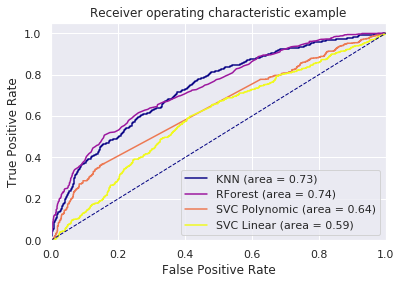

In [13]:
roc({"KNN": knn, "RForest": rf, 
     "SVC Linear": svc_linear,
     "SVC Polynomic": svc_poly})